In [1]:
import matplotlib.pyplot as plt
import gc
import os
import sys

In [2]:
sys.path.append("../")

In [3]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from skopt import BayesSearchCV
from tqdm import tqdm

In [4]:
from utils.eval_helpers import plot_roc_curves, plot_feature_importance, amex_metric
from utils.eda_helpers import plot_missing_proportion_barchart

In [5]:
DATA_PATH = "../raw_data"
os.listdir(DATA_PATH)

['train_labels.csv',
 '.DS_Store',
 'test_data.ftr',
 'train_data.ftr',
 'sample_submission.csv']

In [6]:
PROCESSED_DATA_PATH = "../processed_data"
SUBMISSION_DATA_PATH = "../submissions"
CATEGORY_COLUMNS = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

In [7]:
%load_ext autoreload
%autoreload

### Read Data

In [8]:
train_data = pd.read_feather(f"{DATA_PATH}/train_data.ftr")
test_data = pd.read_feather(f"{DATA_PATH}/test_data.ftr")

In [9]:
train_data["S_2"] = pd.to_datetime(train_data["S_2"])
test_data["S_2"] = pd.to_datetime(test_data["S_2"])

In [10]:
train_data.shape, test_data.shape

((5531451, 190), (11363762, 190))

In [11]:
train_data.columns

Index(['customer_ID', 'S_2', 'P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41',
       'B_3',
       ...
       'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143',
       'D_144', 'D_145'],
      dtype='object', length=190)

In [12]:
train_labels = pd.read_csv(f"{DATA_PATH}/train_labels.csv")

In [13]:
train_labels.shape

(458913, 2)

In [14]:
train_labels.columns

Index(['customer_ID', 'target'], dtype='object')

### Simple Preprocessing

In [15]:
train_data = train_data.sort_values(by=["customer_ID", "S_2"])
test_data = test_data.sort_values(by=["customer_ID", "S_2"])

In [16]:
train_data = train_data.merge(train_labels, on="customer_ID", how="left")

In [17]:
train = train_data.copy()
test = test_data.copy()

#### EDA & Data Cleaning

#### Missing value analysis (Pre Simple Imputation)

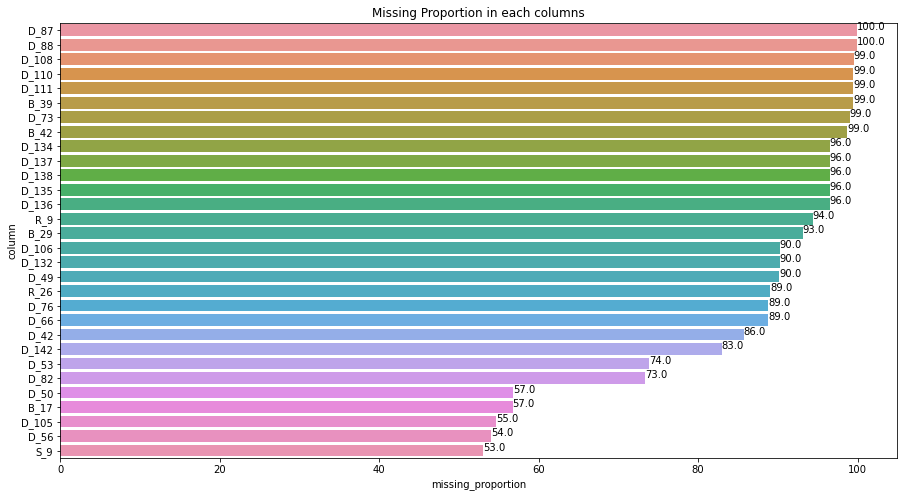

In [18]:
missing_prop_df = plot_missing_proportion_barchart(train)

#### Simple Imputation

In [34]:
def get_cols(df, key):
    return [col for col in df.columns if key in col]

In [19]:
def create_has_col(df, col):
    has_col = f"has_{col}"
    df.loc[:, has_col] = 0
    df.loc[~df[col].isnull(), has_col] = 1
    return df

In [20]:
def create_sign_col(df, col):
    sign_col = f"{col}_sign"
    df[sign_col] = df[col].apply(lambda x: 0 if x == 0 else x / abs(x))
    return df

In [21]:
def apply_all_fillna(df):
    # Simple Fill NA with 0
    for col in ["D_87", "D_88", "B_39", "B_42"]:
        df[col] = df[col].fillna(0)  # .apply(lambda x: (abs(x) + x) / 2).fillna(0)
    # Create has column
    for col in ["D_110", "D_111", "D_132", "D_134", "D_135", "D_136", "D_137", "D_138"]:
        df = create_has_col(df, col=col)
    # Create sign column
    for col in ["B_39"]:
        df = create_sign_col(df, col=col)
    return df

In [22]:
# ! Fill NA
train = apply_all_fillna(train)
test = apply_all_fillna(test)

In [35]:
special_columns = ['customer_ID', 'S_2', 'target'] + get_cols(train, "has") + get_cols(train, "sign")

In [36]:
all_cols = [c for c in train.columns if c not in special_columns]
cat_features = CATEGORY_COLUMNS
num_features = [col for col in all_cols if col not in CATEGORY_COLUMNS]

In [37]:
len(all_cols), len(cat_features), len(num_features)

(188, 11, 177)

In [38]:
def get_agg_summary(original_df):
    agg_summary = original_df.groupby("customer_ID").agg(num_records=("S_2", "count"), 
                                                         max_date=("S_2", "max"),
                                                         min_date=("S_2", "min"))
    agg_summary = agg_summary.reset_index()
    agg_summary["days"] = (agg_summary["max_date"] - agg_summary["min_date"]).dt.days
    agg_summary["record_per_day"] = agg_summary["days"] / agg_summary["num_records"]
    return agg_summary

In [39]:
train_agg_summary = get_agg_summary(train_data)
test_agg_summary = get_agg_summary(test_data)

#### Aggregation

#### Numeric features

In [40]:
train_data_agg = train.groupby("customer_ID")[num_features].agg(['mean', 'std', 'min', 'max', 'last'])

In [41]:
train_data_agg.columns = ['_'.join(x) for x in train_data_agg.columns]

In [42]:
test_data_agg = test_data.groupby("customer_ID")[num_features].agg(['mean', 'std', 'min', 'max', 'last'])

In [43]:
test_data_agg.columns = ['_'.join(x) for x in test_data_agg.columns]

#### Categorical features

In [44]:
train_cat_agg = train_data.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])
test_cat_agg = test_data.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])

In [45]:
train_cat_agg.columns = ['_'.join(x) for x in train_cat_agg.columns]
test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]

In [46]:
train_agg = pd.concat([train_data_agg, train_cat_agg], axis=1)
del train_data_agg, train_cat_agg

In [47]:
train_agg = train_agg.reset_index()

In [48]:
train_agg.shape

(458913, 919)

In [49]:
test_agg = pd.concat([test_data_agg, test_cat_agg], axis=1)
del test_data_agg, test_cat_agg

In [50]:
test_agg = test_agg.reset_index()

In [51]:
test_agg.shape

(924621, 919)

In [54]:
train_agg = train_agg.merge(train_agg_summary[["customer_ID", "days", "record_per_day"]], on="customer_ID")
test_agg = test_agg.merge(test_agg_summary[["customer_ID", "days", "record_per_day"]], on="customer_ID")

### Has_xx col Agg

In [60]:
train_has_col_mean_df = train[["customer_ID"] + get_cols(train, "has") + get_cols(train, "sign")].groupby("customer_ID").agg(["mean"])
test_has_col_mean_df = test[["customer_ID"] + get_cols(test, "has") + get_cols(test, "sign")].groupby("customer_ID").agg(["mean"])

In [61]:
train_has_col_mean_df.columns = ['_'.join(x) for x in train_has_col_mean_df.columns]
test_has_col_mean_df.columns = ['_'.join(x) for x in test_has_col_mean_df.columns]

In [64]:
train_agg = train_agg.merge(train_has_col_mean_df, on="customer_ID")
test_agg = test_agg.merge(test_has_col_mean_df, on="customer_ID")

In [65]:
train_agg.to_feather(f"{PROCESSED_DATA_PATH}/train_agg_data.ftr")

In [66]:
test_agg.to_feather(f"{PROCESSED_DATA_PATH}/test_agg_data.ftr")

In [ ]:
train_cols_unique_count = train_data.nunique()

In [ ]:
less_unique_columns = train_cols_unique_count[train_cols_unique_count <= 300].index.tolist()
print(less_unique_columns)

In [ ]:
for column in less_unique_columns:
    print(f"Column {column}")
    print(train_data[column].unique(), end="\n\n")

In [ ]:
def set_category_columns(df):
    pass

In [ ]:
train_data.loc[:, cat_features].

### Train Val Split

In [ ]:
train_labels.insert(0, "cid", train_labels['customer_ID'].apply(hash).astype('int64'))
train_labels.head(5)

In [ ]:
train_labels = train_labels.sort_values(by="cid").reset_index(drop=True)

In [ ]:
train_ = train_agg.merge(train_labels[["cid", "target"]], on="cid", how="left")

In [ ]:
train_["dummy"] = np.random.randn(train_.shape[0])

In [ ]:
train, val = train_test_split(train_, test_size=0.2, random_state=1020, stratify=train_["target"])

In [ ]:
train["target"].mean(), val["target"].mean()

### LGBM Model

In [ ]:
X_train = train.drop(columns=["cid", "target"])
X_val = val.drop(columns=["cid", "target"])

In [ ]:
y_train = train["target"]
y_val = val["target"]

In [ ]:
opt = BayesSearchCV(
    LGBMClassifier(random_state=1020),
    {
        'learning_rate': (0.01, 0.1),
        'num_leaves': (31, 127),
        'max_depth': (4, 15),
        'min_child_samples': (15, 63),
        'n_estimators': (50, 150),
        'subsample': (0.7, 0.9),
        'subsample_freq': (2, 5),
        'colsample_bytree': (0.7, 0.9),
        'reg_lambda': (0, 10),
        'min_split_gain': (0, 0.05),
    },
    n_iter=10,
    cv=5,
    scoring=make_scorer(fbeta_score, beta=2)
)

In [ ]:
opt.fit(X_train, y_train)

In [ ]:
lgbm_clf = LGBMClassifier(random_state=1020)

In [ ]:
lgbm_clf.fit(X_train, y_train)

In [ ]:
y_train_pred = lgbm_clf.predict_proba(X_train)[:, 1]
y_val_pred = lgbm_clf.predict_proba(X_val)[:, 1]

In [ ]:
plot_roc_curves([y_train, y_val], 
                [y_train_pred, y_val_pred], 
                labels=["Train", "Test"], 
                title="Train Test ROC AUC")

In [ ]:
imp_df = plot_feature_importance(lgbm_clf.feature_name_, 
                                 lgbm_clf.feature_importances_, 
                                 title="Feature Importance",
                                 limit=50)

In [ ]:
num_list, num_features_list, train_score_list, val_score_list = [], [], [], []
for i in tqdm(range(30)):
    selected_features = imp_df.loc[imp_df["feature_importance"] > i]["feature"].tolist()
    print(f"# of features: {len(selected_features)}")
    
    X_train_new = train.loc[:, selected_features]
    X_val_new = val.loc[:, selected_features]
    
    lgbm_clf = LGBMClassifier(random_state=1020)
    lgbm_clf.fit(X_train_new, y_train)
    
    y_train_pred = lgbm_clf.predict_proba(X_train_new)[:, 1]
    y_val_pred = lgbm_clf.predict_proba(X_val_new)[:, 1]
    
    y_train_df = pd.DataFrame(y_train).reset_index(drop=True)
    y_train_pred_df = pd.DataFrame(y_train_pred).rename(columns={0: "prediction"})
    y_val_df = pd.DataFrame(y_val).reset_index(drop=True)
    y_val_pred_df = pd.DataFrame(y_val_pred).rename(columns={0: "prediction"})
    
    train_score = amex_metric(y_train_df, y_train_pred_df)
    val_score = amex_metric(y_val_df, y_val_pred_df)
    num_list.append(i)
    num_features_list.append(len(selected_features))
    train_score_list.append(train_score)
    val_score_list.append(val_score)

In [ ]:
eval_df = pd.DataFrame(dict(index_=num_list, 
                            num_feature=num_features_list, 
                            train_score=train_score_list, 
                            val_score=val_score_list))

In [ ]:
# eval_df

In [ ]:
plt.figure(figsize=(17, 6))
plt.plot(eval_df["index_"], eval_df["train_score"], label="Train")
plt.plot(eval_df["index_"], eval_df["val_score"], label="Validation")
plt.legend()
plt.show()

In [ ]:
selected_features = imp_df.loc[imp_df["feature_importance"] > 5]["feature"].tolist()
len(selected_features)

In [ ]:
X_train_new = train.loc[:, selected_features]
X_val_new = val.loc[:, selected_features]

In [ ]:
lgbm_clf.fit(X_train_new, y_train)

In [ ]:
y_train_pred = lgbm_clf.predict_proba(X_train_new)[:, 1]
y_val_pred = lgbm_clf.predict_proba(X_val_new)[:, 1]

In [ ]:
plot_roc_curves([y_train, y_val], 
                [y_train_pred, y_val_pred], 
                labels=["Train", "Test"], 
                title="Train Test ROC AUC")

In [ ]:
y_train_df = pd.DataFrame(y_train).reset_index(drop=True)
y_train_pred_df = pd.DataFrame(y_train_pred).rename(columns={0: "prediction"})

In [ ]:
amex_metric(y_train_df, y_train_pred_df)

In [ ]:
y_val_df = pd.DataFrame(y_val).reset_index(drop=True)
y_val_pred_df = pd.DataFrame(y_val_pred).rename(columns={0: "prediction"})

In [ ]:
amex_metric(y_val_df, y_val_pred_df)

### Inference

In [ ]:
X_test = test_agg.drop(columns=["cid"])

In [ ]:
X_test = test_agg.loc[:, selected_features]

In [ ]:
y_test_pred = lgbm_clf.predict_proba(X_test)[:, 1]

In [ ]:
test_agg["prediction"] = y_test_pred

#### Submission

In [ ]:
submission = pd.read_csv(f"{DATA_PATH}/sample_submission.csv")

In [ ]:
submission["cid"] = submission['customer_ID'].apply(hash).astype('int64')
submission = submission.drop(columns="prediction")

In [ ]:
result = submission.merge(test_agg[["cid", "prediction"]], on="cid").drop(columns="cid")

In [ ]:
result.to_csv(f"{SUBMISSION_DATA_PATH}/submission3.csv", index=False)